In [2736]:
import math
import numpy as np
import os

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
sns.set_style("ticks")
sns.set_context("paper")
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2737]:
three_d_points = np.array([
    [-0.08, -2.30333333, 1.19666667],  # Top right solar panel
    [-0.15666667, -0.84333333, 1.19666667],  # Top left solar panel
    [-0.08, -2.30333333, -0.78333333],  # Bottom right solar panel
    [-0.15666667, -0.84333333, -0.78333333],  # Bottom left solar panel
    [-0.24333333, 1.03, -0.65333333],  # Bottom left satellite
])

# three_d_points -= np.array([0.2799, -0.1329, -0.1785])

three_d_points_names = [
    'Top right solar panel',
    'Top left solar panel',
    'Bottom right solar panel',
    'Bottom left solar panel',
    'Bottom left satellite'
]


def get_normalized_rotation(roll, pitch, yaw):
    roll_rotation_axis = -19.4321
    pitch_rotation_axis = 0
    yaw_rotation_axis = 179.9654
    r_roll_rotation_axis = np.array([[1, 0, 0],
                                     [0, math.cos(roll_rotation_axis / 180 * math.pi),
                                      -math.sin(roll_rotation_axis / 180 * math.pi)],
                                     [0, math.sin(roll_rotation_axis / 180 * math.pi),
                                      math.cos(roll_rotation_axis / 180 * math.pi)]])

    r_pitch_rotation_axis = np.array(
        [[math.cos(pitch_rotation_axis / 180 * math.pi), 0, math.sin(pitch_rotation_axis / 180 * math.pi)],
         [0, 1, 0],
         [-math.sin(pitch_rotation_axis / 180 * math.pi), 0, math.cos(pitch_rotation_axis / 180 * math.pi)]])

    r_yaw_rotation_axis = np.array(
        [[math.cos(yaw_rotation_axis / 180 * math.pi), -math.sin(yaw_rotation_axis / 180 * math.pi), 0],
         [math.sin(yaw_rotation_axis / 180 * math.pi), math.cos(yaw_rotation_axis / 180 * math.pi), 0],
         [0, 0, 1]])

    rotation_matrix_rotation_axis = r_yaw_rotation_axis @ r_pitch_rotation_axis @ r_roll_rotation_axis

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = (r_yaw @ r_pitch @ r_roll)

    roll = np.rad2deg(math.atan2(rotation_matrix[2, 1], rotation_matrix[2, 2]))
    pitch = np.rad2deg(
        math.atan2(-rotation_matrix[2, 0],
                   math.sqrt(rotation_matrix[2, 1] ** 2 + rotation_matrix[2, 2] ** 2)))
    yaw = np.rad2deg(
        math.atan2(rotation_matrix[1, 0], rotation_matrix[0, 0]))

    return roll, pitch, yaw


def get_rotated_point(roll, pitch, yaw, point=None):
    if point is None:
        point = [-0.08, -2.30333333, 1.19666667]

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = r_yaw @ r_pitch @ r_roll

    rotated_3d_points = np.dot(rotation_matrix, point)

    return rotated_3d_points

In [2738]:
folder = "../test_images/dynamic_unknowndeg_0to360_5degstep/"
suffix = '_eps2_final_strict'
colors = ['red', 'green', 'blue']
normalize = True

In [2739]:
df_true = pd.read_csv(folder + "real_scores.csv")
df_true = df_true.rename(columns={'real_roll': 'roll', 'real_pitch': 'pitch', 'real_yaw':
    'yaw'})
# if normalize:
#     df_true['roll'], df_true['pitch'], df_true['yaw'] = np.vectorize(get_normalized_rotation)(df_true['roll'],
#                                                                                               df_true['pitch'],
#                                                                                               df_true['yaw'])
df_true['img_number'] = df_true.index
# drop first image
df_true = df_true.drop(df_true.index[0])

In [2740]:
df_guess = pd.read_csv(folder + "guesses" + suffix + ".csv")
# drop first image
df_guess = df_guess.drop(df_guess.index[0])
# if normalize:
#     df_guess['roll'], df_guess['pitch'], df_guess['yaw'] = np.vectorize(get_normalized_rotation)(df_guess['roll'],
#                                                                                                  df_guess['pitch'],
#                                                                                                  df_guess['yaw'])
#     df_guess['roll_min'], df_guess['pitch_min'], df_guess['yaw_min'] = np.vectorize(get_normalized_rotation)(
#         df_guess['roll_min'],
#         df_guess['pitch_min'],
#         df_guess['yaw_min'])
#     df_guess['roll_max'], df_guess['pitch_max'], df_guess['yaw_max'] = np.vectorize(get_normalized_rotation)(
#         df_guess['roll_max'],
#         df_guess['pitch_max'],
#         df_guess['yaw_max'])

In [2741]:
df = pd.read_csv(folder + "fine_scores" + suffix + ".csv")
# drop first image
df = df.drop(df.index[0])
if normalize:
    df['roll'], df['pitch'], df['yaw'] = np.vectorize(get_normalized_rotation)(df['roll'],
                                                                               df['pitch'],
                                                                               df['yaw'])

In [2742]:
df_rough = pd.read_csv(folder + "best_scores.csv")
# drop first image
df_rough = df_rough.drop(df_rough.index[0])
df_rough['img_number'] = df_rough['file_name']
if normalize:
    df_rough['roll'], df_rough['pitch'], df_rough['yaw'] = np.vectorize(get_normalized_rotation)(df_rough['roll'],
                                                                                                 df_rough['pitch'],
                                                                                                 df_rough['yaw'])

<Axes: xlabel='img_number', ylabel='x'>

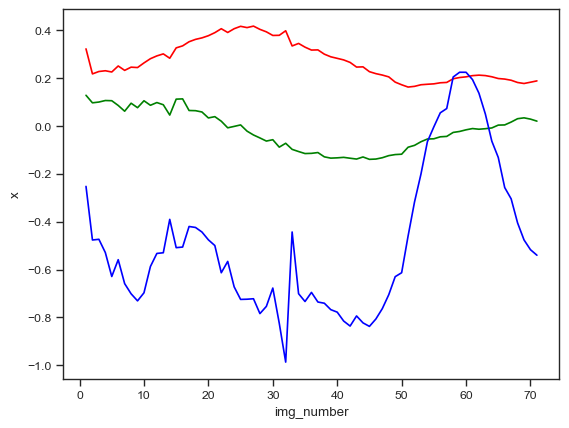

In [2743]:
sns.lineplot(df, x='img_number', y='x', ci=None, color='red')
sns.lineplot(df, x='img_number', y='y', ci=None, color='green')
sns.lineplot(df, x='img_number', y='z', ci=None, color='blue')

In [2744]:
def plot_guess(guess_type, df=df_guess):
    sns.lineplot(data=df, x='img_number', y=guess_type, color='blue', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_min', color='red', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_max', color='green', ci=None)
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='black')
    plt.legend(['Guess', 'Min', 'Max', 'Lowest loss estimate'])
    plt.title('SMA ' + guess_type + ' guesses')
    plt.xlabel('Image number')
    if guess_type in ['roll', 'pitch', 'yaw']:
        plt.ylabel(guess_type + ' (deg)')

    else:
        plt.ylabel(guess_type + ' (m)')

    plt.savefig(folder + "/plots/" + guess_type + '_guesses' + suffix + '.png')
    plt.show()

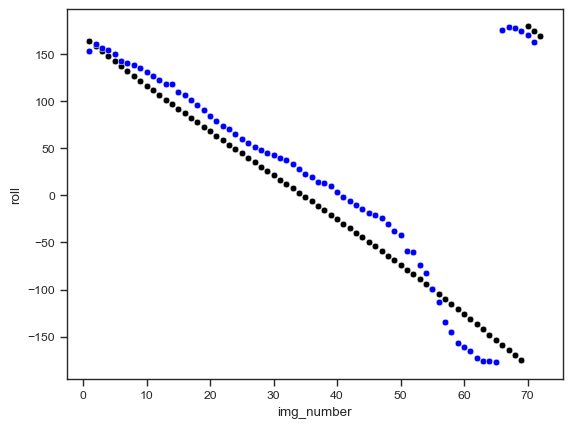

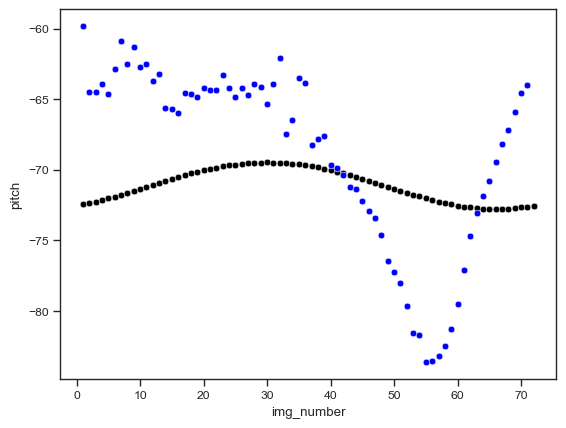

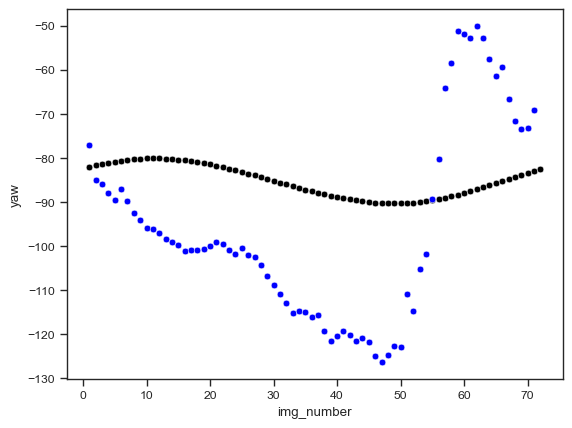

In [2745]:
for guess_type in ['roll', 'pitch', 'yaw']:
    sns.scatterplot(data=df_true, x='img_number', y=guess_type, color='black')
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='blue')
    # sns.scatterplot(data=df_rough, x='img_number', y=guess_type, color='green')
    plt.show()

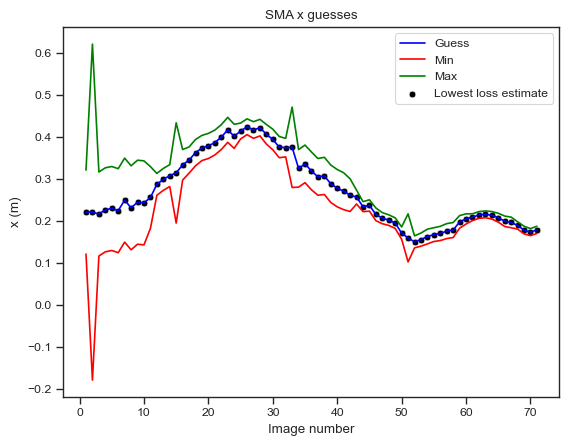

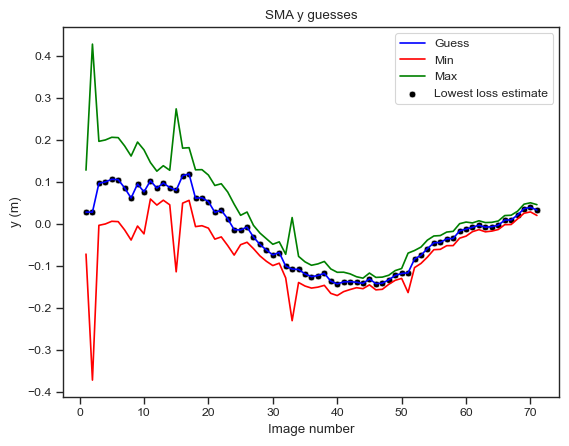

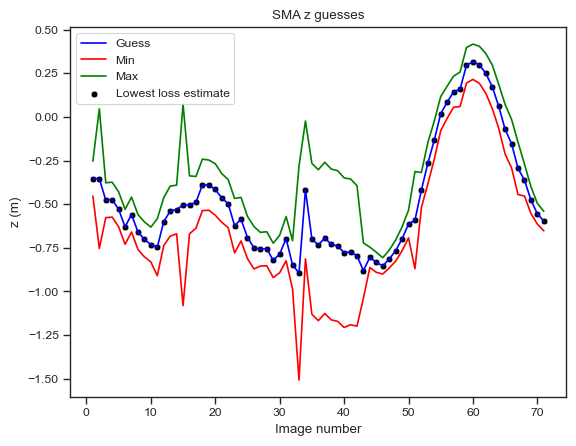

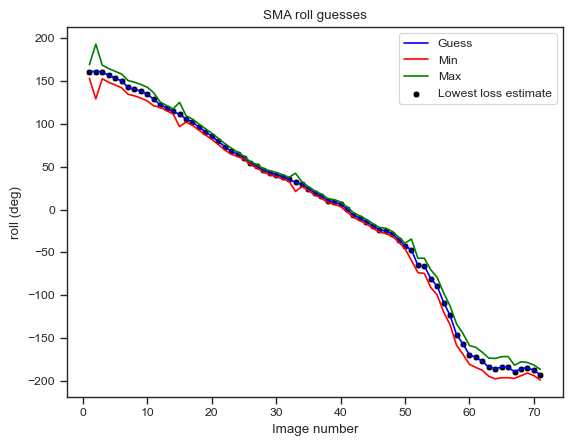

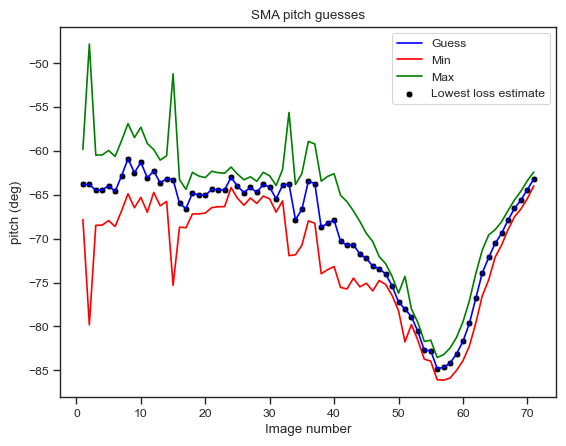

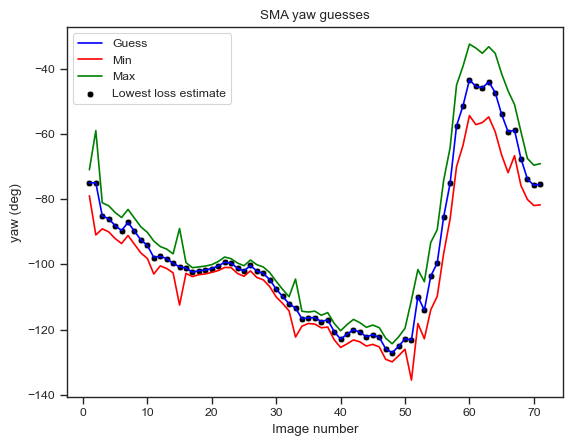

In [2746]:
for guess_type in ['x', 'y', 'z', 'roll', 'pitch', 'yaw']:
    plot_guess(guess_type)

In [2747]:
def plot_translation(trans_type):
    sns.scatterplot(data=df, x='img_number', y=trans_type, color='black')
    mean = df[trans_type].mean()
    plt.axhline(mean, color='red', linestyle='dashed', linewidth=1)
    std = df[trans_type].std()
    plt.axhline(mean + std, color='green', linestyle='dashed', linewidth=1)
    plt.axhline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(trans_type + ' estimates for CoM')
    plt.xlabel('Image number')
    plt.ylabel(trans_type + ' (m)')
    plt.legend([trans_type + ' estimates', 'Mean', 'Standard deviation'])
    plt.show()

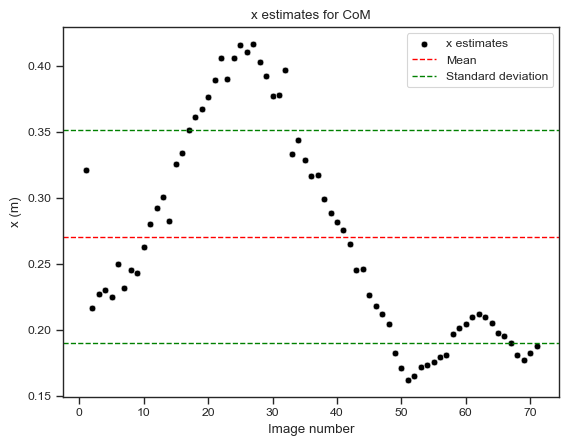

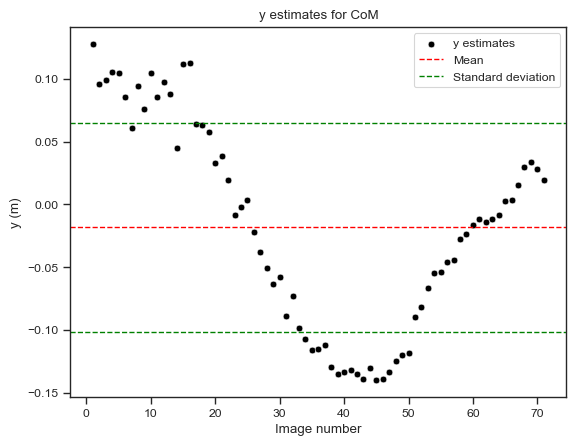

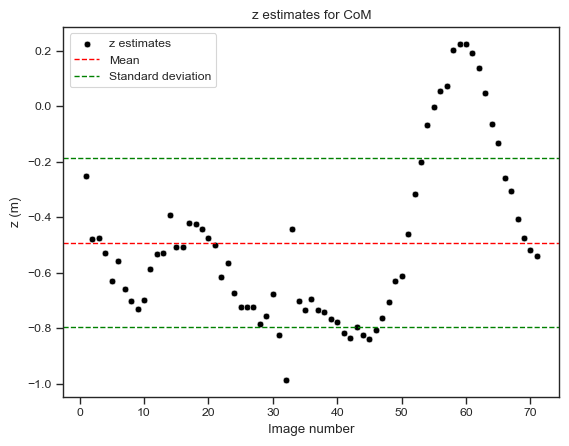

In [2748]:
for i in ['x', 'y', 'z']:
    plot_translation(i)

In [2749]:
df_rotated_points_true = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df_true.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df_true['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points_true = pd.concat([df_local, df_rotated_points_true])

In [2750]:
df_rotated_points_true = df_rotated_points_true.merge(df_true, on='img_number')

In [2751]:
df_rotated_points = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points = pd.concat([df_local, df_rotated_points])
df_rotated_points.to_csv(folder + 'rotated_points.csv')

In [2752]:
df_rotated_points = df_rotated_points.merge(df, on='img_number')

In [2753]:
df_rotated_points_rough = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df_rough.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df_rough['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points_rough = pd.concat([df_local, df_rotated_points_rough])

In [2754]:
df_rotated_points_rough = df_rotated_points_rough.merge(df_rough, on='img_number')

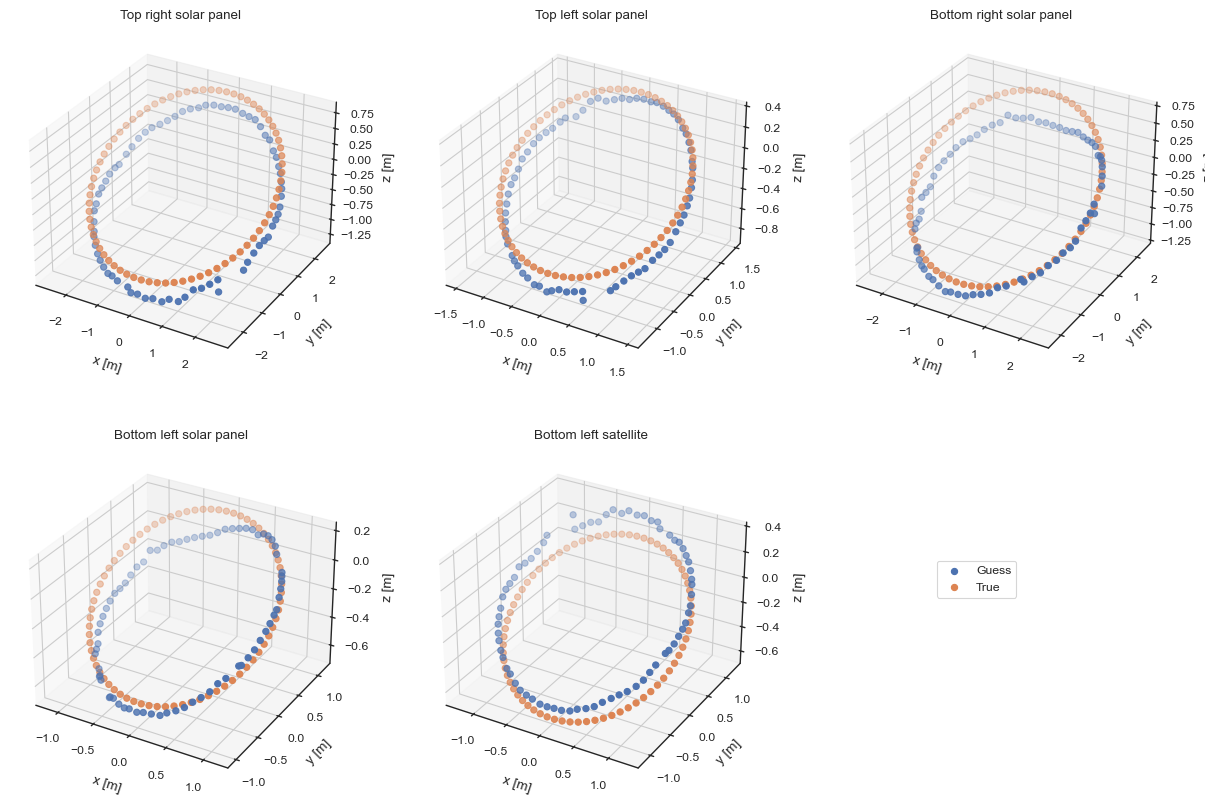

In [2755]:
# 3d subplots
fig = plt.figure(figsize=(15, 10))
for i, point in enumerate(three_d_points):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.title.set_text(three_d_points_names[i])
    # labels
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    ax.scatter(df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['x_point'],
               df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['y_point'],
               df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['z_point'],
               label=three_d_points_names[i])
    ax.scatter(df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['x_point'],
               df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['y_point'],
               df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['z_point'],
               label=three_d_points_names[i] + ' true')

# add legend bottom right in the figure
fig.legend(['Guess', 'True'], loc='lower right', bbox_to_anchor=(0.8, 0.3))
plt.savefig(folder + "/plots/3d_points.png")

In [2756]:
df_rotated_points_all = df_rotated_points.merge(df_rotated_points_true, on=['img_number', '3d_point'],
                                                suffixes=('_fine', '_true'))

In [2757]:
df_rotated_points_all

,x_point_fine,y_point_fine,z_point_fine,img_number,3d_point,iterations,loss,roll_fine,pitch_fine,yaw_fine,x,y,z,x_point_true,y_point_true,z_point_true,roll_true,pitch_true,yaw_true
0,-0.839649,0.861605,0.315567,1,Bottom left satellite,728,1123.213127,153.323242,-59.821898,-77.152341,0.321378,0.127557,-0.252949,-0.922548,0.832925,0.045775,163.308776,-72.457604,-82.078595
1,0.998297,0.593370,0.026096,1,Bottom left solar panel,728,1123.213127,153.323242,-59.821898,-77.152341,0.321378,0.127557,-0.252949,0.949654,0.668962,0.003770,163.308776,-72.457604,-82.078595
2,2.404792,0.293431,-0.237129,1,Bottom right solar panel,728,1123.213127,153.323242,-59.821898,-77.152341,0.321378,0.127557,-0.252949,2.393082,0.442790,-0.049520,163.308776,-72.457604,-82.078595
3,0.471705,-1.095449,-0.863280,1,Top left solar panel,728,1123.213127,153.323242,-59.821898,-77.152341,0.321378,0.127557,-0.252949,0.635617,-1.200529,-0.567880,163.308776,-72.457604,-82.078595
4,1.878199,-1.395388,-1.126506,1,Top right solar panel,728,1123.213127,153.323242,-59.821898,-77.152341,0.321378,0.127557,-0.252949,2.079045,-1.426701,-0.621170,163.308776,-72.457604,-82.078595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,-1.076811,0.593526,0.187512,71,Bottom left satellite,700,2831.009948,162.982091,-63.987199,-69.067058,0.187661,0.019611,-0.540260,-1.048059,0.669694,-0.006231,174.075951,-72.610989,-82.887157
351,0.781510,0.855742,0.079462,71,Bottom left solar panel,700,2831.009948,162.982091,-63.987199,-69.067058,0.187661,0.019611,-0.540260,0.825019,0.815734,0.057336,174.075951,-72.610989,-82.887157
352,2.234651,0.964452,-0.039040,71,Bottom right solar panel,700,2831.009948,162.982091,-63.987199,-69.067058,0.187661,0.019611,-0.540260,2.286689,0.830122,0.085465,174.075951,-72.610989,-82.887157
353,0.848174,-0.940497,-0.750888,71,Top left solar panel,700,2831.009948,162.982091,-63.987199,-69.067058,0.187661,0.019611,-0.540260,0.854953,-1.074525,-0.531243,174.075951,-72.610989,-82.887157


In [2758]:
df_rotated_points_all['residual_roll'] = np.vectorize(min)(
    df_rotated_points_all['roll_fine'] - df_rotated_points_all['roll_true'],
    (df_rotated_points_all['roll_true'] + 360) -
    df_rotated_points_all['roll_fine'])
df_rotated_points_all['residual_pitch'] = np.vectorize(min)(
    df_rotated_points_all['pitch_fine'] - df_rotated_points_all['pitch_true'],
    (df_rotated_points_all['pitch_true'] + 360) -
    df_rotated_points_all['pitch_fine'])
df_rotated_points_all['residual_yaw'] = np.vectorize(min)(
    df_rotated_points_all['yaw_fine'] - df_rotated_points_all['yaw_true'],
    (df_rotated_points_all['yaw_true'] + 360) -
    df_rotated_points_all['yaw_fine'])
df_rotated_points_all['residual_x'] = df_rotated_points_all['x_point_fine'] - df_rotated_points_all['x_point_true']
df_rotated_points_all['residual_y'] = df_rotated_points_all['y_point_fine'] - df_rotated_points_all['y_point_true']
df_rotated_points_all['residual_z'] = df_rotated_points_all['z_point_fine'] - df_rotated_points_all['z_point_true']

In [2759]:
# for var in ['x', 'y', 'z']:
#     g = sns.displot(data=df_rotated_points_all, x='residual_' + var, hue='3d_point', kind='kde');
#     g.fig.subplots_adjust(top=0.9)
#     g.fig.suptitle('Residuals for rotated ' + var + ' point')
#     for ax in g.axes.flat:
#         ax.set(xlabel='Independent variable ' + var + ' [m]')

In [2760]:
# only show top right solar panel
df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']

,x_point_fine,y_point_fine,z_point_fine,img_number,3d_point,iterations,loss,roll_fine,pitch_fine,yaw_fine,...,z_point_true,roll_true,pitch_true,yaw_true,residual_roll,residual_pitch,residual_yaw,residual_x,residual_y,residual_z
4,1.878199,-1.395388,-1.126506,1,Top right solar panel,728,1.123213e+03,153.323242,-59.821898,-77.152341,...,-0.621170,163.308776,-72.457604,-82.078595,-9.985534,12.635706,4.926253,-0.200846,0.031313,-0.505336
9,1.918182,-1.510037,-0.885505,2,Top right solar panel,490,3.517797e-11,160.791879,-64.480795,-85.072976,...,-0.674097,157.965424,-72.364579,-81.716239,2.826455,7.883784,-3.356737,-0.017833,0.084074,-0.211408
14,1.761921,-1.660566,-0.939100,3,Top right solar panel,651,1.230418e-09,156.693282,-64.454293,-86.003940,...,-0.722410,152.652682,-72.261787,-81.385815,4.040600,7.807494,-4.618125,-0.016316,0.088648,-0.216690
19,1.593631,-1.794318,-0.992229,4,Top right solar panel,1246,3.978089e-10,153.626644,-63.943973,-88.061305,...,-0.765740,147.372862,-72.150169,-81.089769,6.253782,8.206196,-6.971536,-0.013279,0.096512,-0.226489
24,1.422304,-1.925390,-1.006817,5,Top right solar panel,1015,1.890654e+00,150.311431,-64.620556,-89.583903,...,-0.803757,142.127840,-72.030723,-80.830102,8.183591,7.410166,-8.753801,-0.001035,0.092489,-0.203060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2.533259,-0.160130,-0.548371,67,Top right solar panel,392,5.652767e-01,178.077737,-68.138035,-66.628908,...,-0.231302,-164.168148,-72.768985,-84.734824,17.754116,4.630950,18.105915,-0.042097,0.080278,-0.317069
339,2.505875,-0.373201,-0.570148,68,Top right solar panel,434,6.444385e-02,177.921739,-67.169648,-71.522941,...,-0.302458,-169.624692,-72.749279,-84.254640,12.453570,5.579631,12.731699,-0.033350,0.079142,-0.267690
344,2.451164,-0.566357,-0.644042,69,Top right solar panel,392,1.236627e-11,174.830074,-65.917620,-73.350599,...,-0.371828,-175.072395,-72.716139,-83.783647,10.097531,6.798519,10.433047,-0.032589,0.094302,-0.272214
349,2.370463,-0.745420,-0.754329,70,Top right solar panel,371,4.026313e-01,169.699575,-64.584385,-73.134380,...,-0.438883,179.493106,-72.669892,-83.326381,-9.793530,8.085507,10.192001,-0.038901,0.118353,-0.315446


In [ ]:
g = sns.PairGrid(df_rotated_points_all, vars=['residual_x', 'residual_y', 'residual_z'])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.histplot)
# share x and y axis

In [ ]:
sns.FacetGrid(df_rotated_points_all, col='3d_point', hue='3d_point', col_wrap=3, height=4) \
    .map(sns.kdeplot, 'residual_x', 'residual_z')

In [ ]:
for var in ['x', 'y', 'z']:
    g = sns.histplot(data=df_rotated_points_all,
                     x='residual_' + var,
                     hue='3d_point',
                     kde=True, stat='density',
                     bins=20);
    # stack
    # g = sns.histplot(data=df_rotated_points_all, x='residual_' + var, hue='3d_point', kde=True, stat='density',
    #                  bins=20, multiple='stack');
    # mean = df_rotated_points_all['residual_' + var].mean()
    # plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
    g.set_title('Residuals for rotated point')
    g.set(xlabel='Independent variable ' + var + ' [m]')
    plt.savefig(folder + "/plots/" + var + '_residuals.png')
    plt.show()